In [ ]:
!pip install pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, expr
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# Create Spark Session
spark = SparkSession.builder \
    .appName("Employee Attrition Prediction") \
    .getOrCreate()

# Load Dataset
# Replace 'your_dataset_path.csv' with the actual path to your dataset in Colab
file_path = "/content/WA_Fn-UseC_-HR-Employee-Attrition.csv"  # Ensure this file is uploaded in Colab
data = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
# Display Data
data.show(5)

+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

# **Data Preprocessing**

In [ ]:
# Encode Categorical Variables
# StringIndexer for categorical columns
indexers = [
    StringIndexer(inputCol=column, outputCol=column + "_Index")
    for column in ['Gender', 'JobRole', 'Department', 'BusinessTravel']
]

In [ ]:

# Apply StringIndexer
for indexer in indexers:
    data = indexer.fit(data).transform(data)

# OneHotEncoder for indexed columns
encoder = OneHotEncoder(
    inputCols=['Gender_Index', 'JobRole_Index', 'Department_Index', 'BusinessTravel_Index'],
    outputCols=['Gender_OHE', 'JobRole_OHE', 'Department_OHE', 'BusinessTravel_OHE']
)
data = encoder.fit(data).transform(data)

In [ ]:
# Feature Scaling
# VectorAssembler for continuous features
assembler = VectorAssembler(inputCols=['MonthlyIncome', 'YearsAtCompany'], outputCol='ContinuousFeatures')
data = assembler.transform(data)

# StandardScaler for normalization
scaler = StandardScaler(inputCol='ContinuousFeatures', outputCol='ScaledFeatures', withStd=True, withMean=True)
data = scaler.fit(data).transform(data)

In [ ]:
# Feature Engineering
# Create 'Tenure' feature
data = data.withColumn("Tenure", col("YearsAtCompany") - col("YearsInCurrentRole"))

# Create 'IncomeToJobLevelRatio' feature
data = data.withColumn("IncomeToJobLevelRatio", col("MonthlyIncome") / col("JobLevel"))

In [ ]:
data.show(5)

+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+------------+-------------+----------------+--------------------+-------------+-------------+--------------+------------------+------------------+--------------------+------+---------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyInco

In [ ]:
data.select(
     "Tenure", "IncomeToJobLevelRatio").show(5)

+------+---------------------+
|Tenure|IncomeToJobLevelRatio|
+------+---------------------+
|     2|               2996.5|
|     3|               2565.0|
|     0|               2090.0|
|     1|               2909.0|
|     0|               3468.0|
+------+---------------------+
only showing top 5 rows



# **EDA**

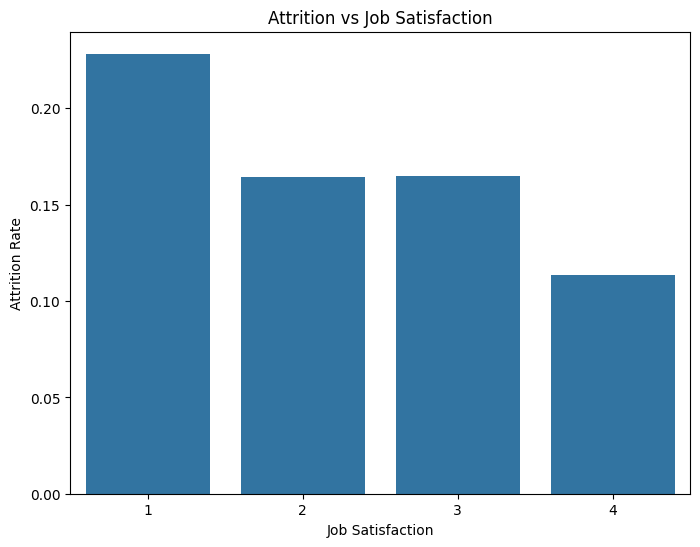

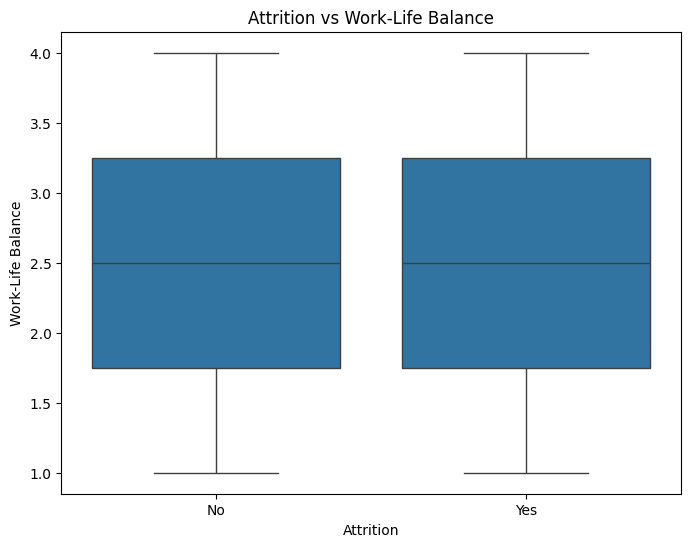

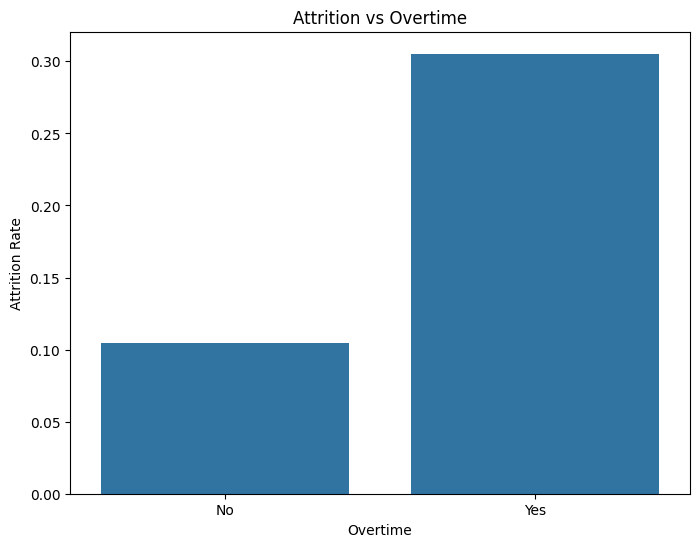

In [ ]:
from pyspark.sql.functions import col, when, count, avg
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Visualize Relationships
# Attrition vs Job Satisfaction
attrition_job_satisfaction = data.groupBy("JobSatisfaction").agg(
    avg(when(col("Attrition") == "Yes", 1).otherwise(0)).alias("AttritionRate")
).orderBy("JobSatisfaction")

attrition_job_satisfaction_pd = attrition_job_satisfaction.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=attrition_job_satisfaction_pd, x="JobSatisfaction", y="AttritionRate")
plt.title("Attrition vs Job Satisfaction")
plt.xlabel("Job Satisfaction")
plt.ylabel("Attrition Rate")
plt.show()

# Attrition vs Work-Life Balance
attrition_work_life = data.groupBy("WorkLifeBalance", "Attrition").count().orderBy("WorkLifeBalance", "Attrition")
attrition_work_life_pd = attrition_work_life.toPandas()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Attrition', y='WorkLifeBalance', data=attrition_work_life_pd)
plt.title("Attrition vs Work-Life Balance")
plt.ylabel("Work-Life Balance")
plt.xlabel("Attrition")
plt.show()

# Attrition vs Overtime
attrition_overtime = data.groupBy("OverTime").agg(
    avg(when(col("Attrition") == "Yes", 1).otherwise(0)).alias("AttritionRate")
).orderBy("OverTime")

attrition_overtime_pd = attrition_overtime.toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=attrition_overtime_pd, x="OverTime", y="AttritionRate")
plt.title("Attrition vs Overtime")
plt.xlabel("Overtime")
plt.ylabel("Attrition Rate")
plt.show()

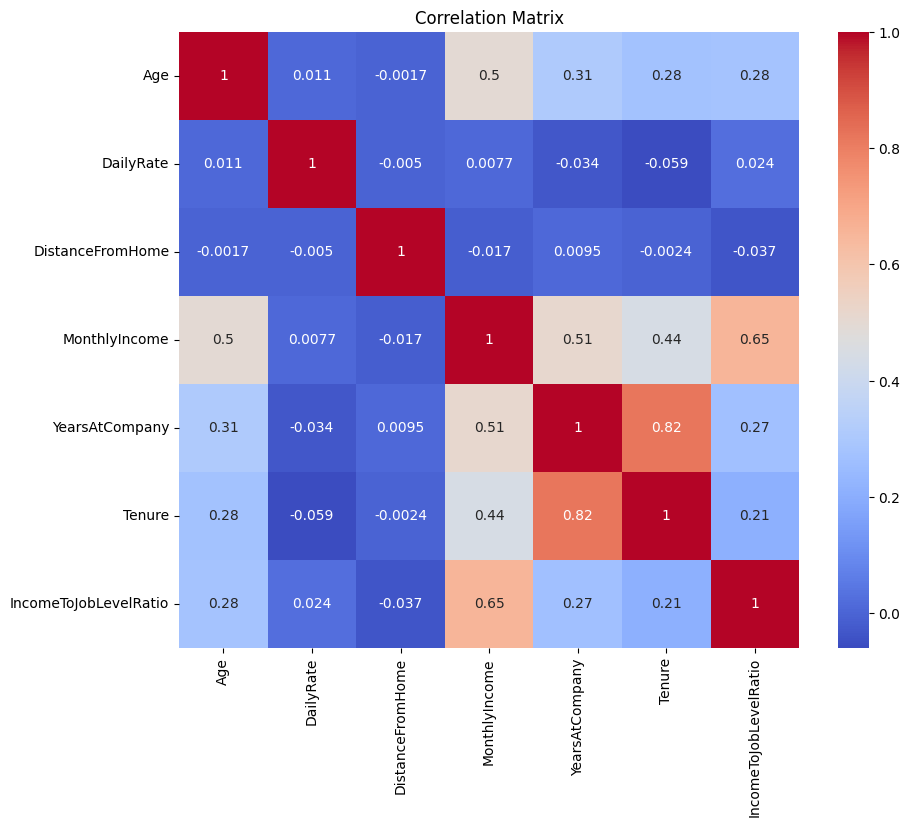

In [ ]:
# 2. Correlation Analysis
numerical_columns = ['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome', 'YearsAtCompany', 'Tenure', 'IncomeToJobLevelRatio']

# Create a correlation matrix
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numerical_columns, outputCol=vector_col)
data_vector = assembler.transform(data).select(vector_col)

from pyspark.ml.stat import Correlation

correlation_matrix = Correlation.corr(data_vector, vector_col).head()[0]
correlation_array = correlation_matrix.toArray()

# Heatmap for correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_array, annot=True, xticklabels=numerical_columns, yticklabels=numerical_columns, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

<ipython-input-12-28a521fd1090>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_balance_pd, x="Attrition", y="count", palette="Set2")


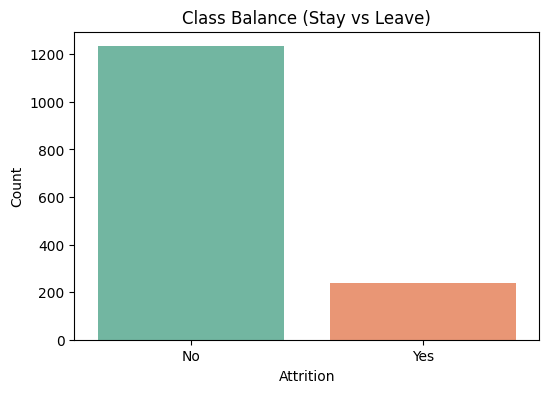

+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+



In [ ]:
# 3. Class Balance Check
class_balance = data.groupBy("Attrition").count().orderBy("Attrition")
class_balance_pd = class_balance.toPandas()

# Visualize Class Balance
plt.figure(figsize=(6, 4))
sns.barplot(data=class_balance_pd, x="Attrition", y="count", palette="Set2")
plt.title("Class Balance (Stay vs Leave)")
plt.ylabel("Count")
plt.xlabel("Attrition")
plt.show()

# Print Class Balance
class_balance.show()

# **Model Training**

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Correctly encode the 'OverTime' column (or any missing column)
indexer = StringIndexer(inputCol="OverTime", outputCol="OverTime_Index")
data = indexer.fit(data).transform(data)

# Confirm that all required columns are indexed
feature_columns = ['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome',
                   'YearsAtCompany', 'Tenure', 'IncomeToJobLevelRatio',
                   'JobSatisfaction', 'WorkLifeBalance', 'OverTime_Index',
                   'JobRole_Index', 'Department_Index', 'BusinessTravel_Index']

# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)

# Display schema to verify 'features' column is created
data.printSchema()


root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

In [ ]:
from pyspark.ml.feature import StringIndexer

# Index the Attrition column
attrition_indexer = StringIndexer(inputCol="Attrition", outputCol="Attrition_Index")
data = attrition_indexer.fit(data).transform(data)

# Confirm the new column is added
data.select("Attrition", "Attrition_Index").show(5)


+---------+---------------+
|Attrition|Attrition_Index|
+---------+---------------+
|      Yes|            1.0|
|       No|            0.0|
|      Yes|            1.0|
|       No|            0.0|
|       No|            0.0|
+---------+---------------+
only showing top 5 rows



In [ ]:
# Split the data into training (80%) and testing (20%) sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


**Logistic Regression(before Hyperparameer Tuning)**

In [ ]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

In [ ]:
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="Attrition_Index")
lr_model = lr.fit(train_data)

# Predict on test data
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Attrition_Index", rawPredictionCol="rawPrediction")
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc}")

Logistic Regression AUC: 0.7341839447102594


**Gradient Boosting Classifier(before Hyperparameer Tuning)**

In [ ]:
# 3. Gradient Boosting Classifier
gbt = GBTClassifier(featuresCol="features", labelCol="Attrition_Index", maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate Gradient Boosting
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosting Classifier AUC: {gbt_auc}")

Gradient Boosting Classifier AUC: 0.6933545986177572


**KNN(before Hyperparameer Tuning)**

In [ ]:

# 4. K-Nearest Neighbors (KNN)
# Convert PySpark DataFrame to Pandas DataFrame for compatibility with sklearn
train_pd = train_data.select("features", "Attrition_Index").toPandas()
test_pd = test_data.select("features", "Attrition_Index").toPandas()

# Convert Spark MLlib vectors to numpy arrays
X_train = np.array([np.array(x) for x in train_pd["features"]])
y_train = train_pd["Attrition_Index"]
X_test = np.array([np.array(x) for x in test_pd["features"]])
y_test = test_pd["Attrition_Index"]

# Train KNN Model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and Evaluate KNN
knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print(f"KNN Accuracy: {knn_accuracy}")
print("KNN Classification Report:")
print(classification_report(y_test, knn_predictions))

KNN Accuracy: 0.8267716535433071
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.98      0.90       209
         1.0       0.55      0.13      0.21        45

    accuracy                           0.83       254
   macro avg       0.69      0.55      0.56       254
weighted avg       0.79      0.83      0.78       254



**Logistic Regression after Hyperparameter Tuning**

In [ ]:
#hyperparameter tuning Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="Attrition_Index")

# Create ParamGrid for Logistic Regression
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 0.5])         # Regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])   # Elastic Net mixing parameter
             .addGrid(lr.maxIter, [10, 50, 100])             # Number of iterations
             .build())

# Define CrossValidator
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="Attrition_Index"),
                          numFolds=3)  # 3-fold cross-validation

# Fit the CrossValidator
cv_model = crossval.fit(train_data)

# Best Model from CrossValidator
best_lr_model = cv_model.bestModel

# Test the Best Model
lr_predictions = best_lr_model.transform(test_data)

# Evaluate the tuned Logistic Regression Model
evaluator = BinaryClassificationEvaluator(labelCol="Attrition_Index", rawPredictionCol="rawPrediction")
lr_auc = evaluator.evaluate(lr_predictions)

# Output Results
print(f"Tuned Logistic Regression AUC: {lr_auc}")
print(f"Best Regularization Parameter (regParam): {best_lr_model._java_obj.getRegParam()}")
print(f"Best ElasticNet Parameter (elasticNetParam): {best_lr_model._java_obj.getElasticNetParam()}")
print(f"Best Max Iterations (maxIter): {best_lr_model._java_obj.getMaxIter()}")


Tuned Logistic Regression AUC: 0.729930887825624
Best Regularization Parameter (regParam): 0.01
Best ElasticNet Parameter (elasticNetParam): 0.0
Best Max Iterations (maxIter): 10


**Gradient Boosting classifier after Hyperparameter Tuning**

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Gradient Boosting Model
gbt = GBTClassifier(featuresCol="features", labelCol="Attrition_Index", seed=42)

# Create ParamGrid for Gradient Boosting
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [3, 5, 7])  # Try different tree depths
             .addGrid(gbt.maxIter, [10, 20])    # Number of iterations (n_estimators)
             .addGrid(gbt.stepSize, [0.1, 0.2]) # Learning rate
             .build())

# CrossValidator for Gradient Boosting
cv = CrossValidator(estimator=gbt,
                    estimatorParamMaps=paramGrid,
                    evaluator=BinaryClassificationEvaluator(labelCol="Attrition_Index"),
                    numFolds=3)  # 3-fold cross-validation

# Fit the CrossValidator
cv_model = cv.fit(train_data)

# Best Model from CrossValidator
best_gbt_model = cv_model.bestModel

# Test on the test data
gbt_predictions = best_gbt_model.transform(test_data)

# Evaluate the tuned Gradient Boosting Model
evaluator = BinaryClassificationEvaluator(labelCol="Attrition_Index")
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Tuned Gradient Boosting AUC: {gbt_auc}")

# Print the best parameters
print(f"Best maxDepth: {best_gbt_model.getMaxDepth()}")
print(f"Best maxIter: {best_gbt_model.getMaxIter()}")
print(f"Best stepSize: {best_gbt_model.getStepSize()}")


Tuned Gradient Boosting AUC: 0.7415736310473147
Best maxDepth: 3
Best maxIter: 20
Best stepSize: 0.1


**KNN after Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Convert Spark DataFrame to Pandas DataFrame for Scikit-learn
train_pd = train_data.select("features", "Attrition_Index").toPandas()
test_pd = test_data.select("features", "Attrition_Index").toPandas()

# Convert PySpark Vectors to Numpy Arrays
X_train = np.array([np.array(x) for x in train_pd["features"]])
y_train = train_pd["Attrition_Index"]
X_test = np.array([np.array(x) for x in test_pd["features"]])
y_test = test_pd["Attrition_Index"]

# Define KNN Model
knn = KNeighborsClassifier()

# Create ParamGrid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance']
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best Model from Grid Search
best_knn_model = grid_search.best_estimator_

# Test the best KNN model
knn_predictions = best_knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)

# Display results
print(f"Tuned KNN Accuracy: {knn_accuracy}")
print("KNN Classification Report:")
print(classification_report(y_test, knn_predictions))

# Best Parameters for KNN
print(f"Best Parameters: {grid_search.best_params_}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuned KNN Accuracy: 0.8188976377952756
KNN Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90       209
         1.0       0.33      0.02      0.04        45

    accuracy                           0.82       254
   macro avg       0.58      0.51      0.47       254
weighted avg       0.74      0.82      0.75       254

Best Parameters: {'n_neighbors': 10, 'weights': 'uniform'}


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


# **Evaluation**

**Logistic Regression Predictions**



In [ ]:
from pyspark.sql.functions import col, udf, when
from pyspark.sql.types import DoubleType
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
import numpy as np

# Logistic Regression Predictions
predictions = lr_predictions  # Assign predictions from Logistic Regression

# 1. Extract Probability of Positive Class
extract_positive_prob = udf(lambda prob: float(prob[1]), DoubleType())
predictions = predictions.withColumn("positive_probability", extract_positive_prob(col("probability")))

# Add Predicted Label
predictions = predictions.withColumn("predicted_label", when(col("positive_probability") > 0.5, 1).otherwise(0))

# 2. Extract True Labels and Predicted Labels
true_labels = np.array(predictions.select("Attrition_Index").rdd.flatMap(lambda x: x).collect())
predicted_labels = np.array(predictions.select("predicted_label").rdd.flatMap(lambda x: x).collect())
probabilities = np.array(predictions.select("positive_probability").rdd.flatMap(lambda x: x).collect())

# 3. Classification Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, probabilities)

# 4. Regression Metrics (based on probabilities)
mse = mean_squared_error(true_labels, probabilities)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, probabilities)
r2 = r2_score(true_labels, probabilities)

# Avoid division by zero in MAPE calculation
true_labels_adjusted = np.where(true_labels == 0, 1e-10, true_labels)
mape = np.mean(np.abs((true_labels - probabilities) / true_labels_adjusted)) * 100

# 5. Print Metrics
print("Logistic Regression Evaluation")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {auc:.4f}")
print("\nRegression Metrics (based on probabilities):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Logistic Regression Evaluation
Accuracy: 0.8307
Precision: 0.6250
Recall: 0.1111
F1-Score: 0.1887
ROC-AUC Score: 0.7299

Regression Metrics (based on probabilities):
MSE: 0.1257
RMSE: 0.3546
MAE: 0.2310
R-squared: 0.1375
MAPE: 98492679915.18%


**Gradient Boosting Classifier Predictions**

In [ ]:
from pyspark.sql.functions import col, udf, when
from pyspark.sql.types import DoubleType
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
import numpy as np

# Gradient Boosting Classifier Predictions
predictions = gbt_predictions  # Assign predictions from Gradient Boosting Classifier

# 1. Extract Probability of Positive Class
extract_positive_prob = udf(lambda prob: float(prob[1]), DoubleType())
predictions = predictions.withColumn("positive_probability", extract_positive_prob(col("probability")))

# Add Predicted Label
predictions = predictions.withColumn("predicted_label", when(col("positive_probability") > 0.5, 1).otherwise(0))

# 2. Extract True Labels and Predicted Labels
true_labels = np.array(predictions.select("Attrition_Index").rdd.flatMap(lambda x: x).collect())
predicted_labels = np.array(predictions.select("predicted_label").rdd.flatMap(lambda x: x).collect())
probabilities = np.array(predictions.select("positive_probability").rdd.flatMap(lambda x: x).collect())

# 3. Classification Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, probabilities)

# 4. Regression Metrics (based on probabilities)
mse = mean_squared_error(true_labels, probabilities)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, probabilities)
r2 = r2_score(true_labels, probabilities)

# Avoid division by zero in MAPE calculation
true_labels_adjusted = np.where(true_labels == 0, 1e-10, true_labels)
mape = np.mean(np.abs((true_labels - probabilities) / true_labels_adjusted)) * 100

# 5. Print Metrics
print("Gradient Boosting Classifier Evaluation")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {auc:.4f}")
print("\nRegression Metrics (based on probabilities):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Gradient Boosting Classifier Evaluation
Accuracy: 0.8504
Precision: 0.7333
Recall: 0.2444
F1-Score: 0.3667
ROC-AUC Score: 0.7416

Regression Metrics (based on probabilities):
MSE: 0.1166
RMSE: 0.3415
MAE: 0.2276
R-squared: 0.2002
MAPE: 107751204800.27%


**KNN Predictions**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Ensure data is ready
# Replace `data` with your dataset and `features`/`target` columns
X = data.select(feature_columns).toPandas().values
y = data.select("Attrition_Index").toPandas().values.ravel()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn_model.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
import numpy as np

# KNN Predictions
knn_predictions = knn_model.predict(X_test)
knn_probabilities = knn_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

# True Labels
true_labels = y_test

# 1. Classification Metrics
accuracy = accuracy_score(true_labels, knn_predictions)
precision = precision_score(true_labels, knn_predictions)
recall = recall_score(true_labels, knn_predictions)
f1 = f1_score(true_labels, knn_predictions)
auc = roc_auc_score(true_labels, knn_probabilities)

# 2. Regression Metrics (based on probabilities)
mse = mean_squared_error(true_labels, knn_probabilities)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_labels, knn_probabilities)
r2 = r2_score(true_labels, knn_probabilities)

# Avoid division by zero in MAPE calculation
true_labels_adjusted = np.where(true_labels == 0, 1e-10, true_labels)
mape = np.mean(np.abs((true_labels - knn_probabilities) / true_labels_adjusted)) * 100

# 3. Print Metrics
print("K-Nearest Neighbors (KNN) Evaluation")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {auc:.4f}")
print("\nRegression Metrics (based on probabilities):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


K-Nearest Neighbors (KNN) Evaluation
Accuracy: 0.8810
Precision: 0.7000
Recall: 0.1795
F1-Score: 0.2857
ROC-AUC Score: 0.6657

Regression Metrics (based on probabilities):
MSE: 0.1109
RMSE: 0.3330
MAE: 0.1871
R-squared: 0.0363
MAPE: 85034013615.65%


# **Visualizations**

**1. Logistic Regression - Confusion Matrix**

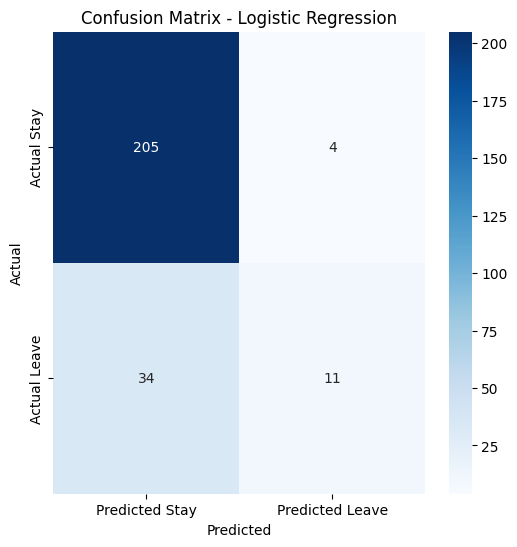

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure alignment of labels
# Assuming `predictions` is the DataFrame with true and predicted labels
true_labels = np.array(predictions.select("Attrition_Index").rdd.flatMap(lambda x: x).collect())
predicted_labels = np.array(predictions.select("predicted_label").rdd.flatMap(lambda x: x).collect())

# Check for mismatches
if len(true_labels) != len(predicted_labels):
    print(f"Mismatch detected: true_labels = {len(true_labels)}, predicted_labels = {len(predicted_labels)}")
    # Align lengths
    min_length = min(len(true_labels), len(predicted_labels))
    true_labels = true_labels[:min_length]
    predicted_labels = predicted_labels[:min_length]

# Compute confusion matrix
conf_matrix_lr = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Stay", "Predicted Leave"],
            yticklabels=["Actual Stay", "Actual Leave"])
plt.title("Confusion Matrix - Logistic Regression")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


**2. Gradient Boosting Classifier - Confusion Matrix**

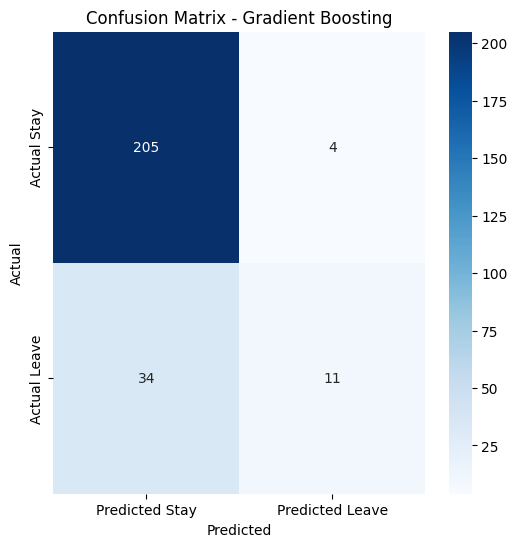

In [ ]:
# For Gradient Boosting, use the predictions already made (e.g., `gbt_predictions`)
conf_matrix_gbt = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_gbt, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Stay", "Predicted Leave"],
            yticklabels=["Actual Stay", "Actual Leave"])
plt.title("Confusion Matrix - Gradient Boosting")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


**3. K-Nearest Neighbors (KNN) - Confusion Matrix**

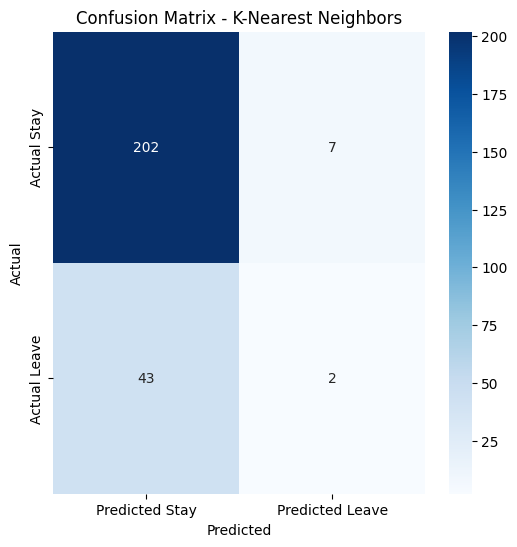

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Align lengths if there's a mismatch
min_length = min(len(true_labels), len(knn_predictions))
true_labels = true_labels[:min_length]
knn_predictions = knn_predictions[:min_length]

# Compute confusion matrix
conf_matrix_knn = confusion_matrix(true_labels, knn_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Stay", "Predicted Leave"],
            yticklabels=["Actual Stay", "Actual Leave"])
plt.title("Confusion Matrix - K-Nearest Neighbors")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


**ROC Curve for LOGISTIC REGRESSION**

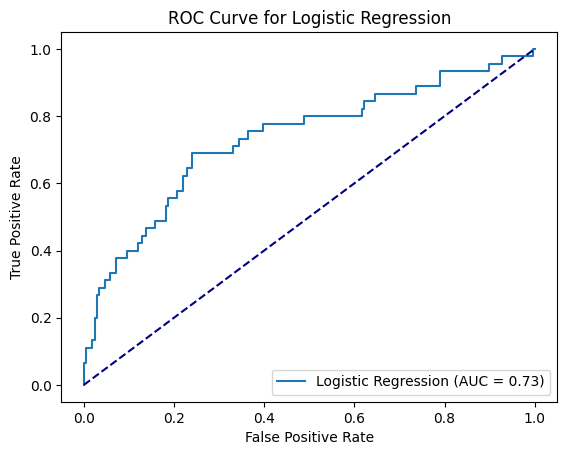

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for the positive class (Attrition=Yes)
logistic_predictions = lr_model.transform(test_data)

# Extract probabilities for the positive class (Attrition=Yes)
probabilities_lr = logistic_predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
true_labels_lr = logistic_predictions.select("Attrition_Index").rdd.flatMap(lambda x: x).collect()

# Calculate FPR, TPR, and thresholds for ROC
fpr_lr, tpr_lr, thresholds_lr = roc_curve(true_labels_lr, probabilities_lr)

# Calculate AUC (Area Under the Curve)
auc_lr = roc_auc_score(true_labels_lr, probabilities_lr)

# Plot ROC curve
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % auc_lr)

# Finalize plot
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()


**ROC Curve for Gradient Boosting Classifier**

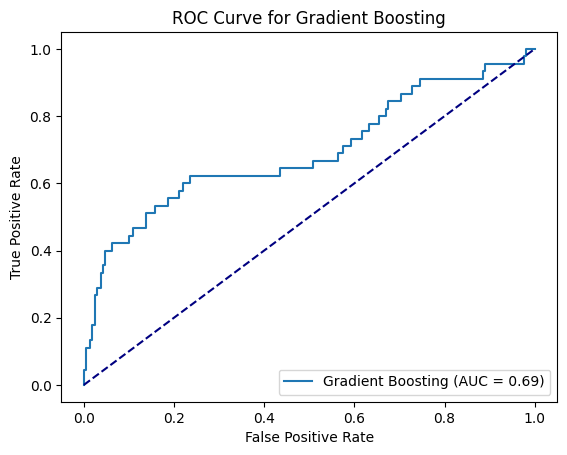

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming `gbt_model` is your trained Gradient Boosting model

# Get predicted probabilities for the positive class (Attrition=Yes)
gbt_predictions = gbt_model.transform(test_data)

# Extract probabilities for the positive class (Attrition=Yes)
probabilities_gbt = gbt_predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
true_labels_gbt = gbt_predictions.select("Attrition_Index").rdd.flatMap(lambda x: x).collect()

# Calculate FPR, TPR, and thresholds for ROC
fpr_gbt, tpr_gbt, thresholds_gbt = roc_curve(true_labels_gbt, probabilities_gbt)

# Calculate AUC (Area Under the Curve)
auc_gbt = roc_auc_score(true_labels_gbt, probabilities_gbt)

# Plot ROC curve
plt.plot(fpr_gbt, tpr_gbt, label='Gradient Boosting (AUC = %0.2f)' % auc_gbt)

# Finalize plot
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting')
plt.legend(loc='lower right')
plt.show()


**ROC Curve for KNN**

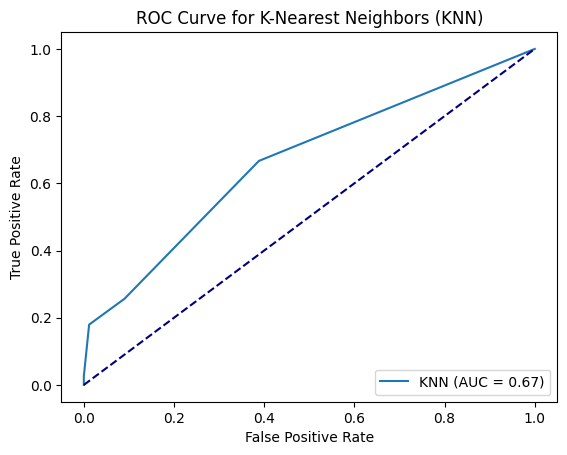

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get KNN predictions and probabilities
# `knn_model` is the trained KNN model
knn_predictions = knn_model.predict(X_test)  # Replace X_test with your test features
knn_probabilities = knn_model.predict_proba(X_test)[:, 1]  # Probability of the positive class (Attrition=Yes)

# True Labels
true_labels_knn = y_test  # Replace y_test with your test labels

# Calculate FPR, TPR, and thresholds for ROC
fpr_knn, tpr_knn, thresholds_knn = roc_curve(true_labels_knn, knn_probabilities)

# Calculate AUC (Area Under the Curve)
auc_knn = roc_auc_score(true_labels_knn, knn_probabilities)

# Plot ROC curve
plt.plot(fpr_knn, tpr_knn, label='KNN (AUC = %0.2f)' % auc_knn)

# Finalize plot
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for K-Nearest Neighbors (KNN)')
plt.legend(loc='lower right')
plt.show()


**Feature Importance for Gradient Boosting Classifier**

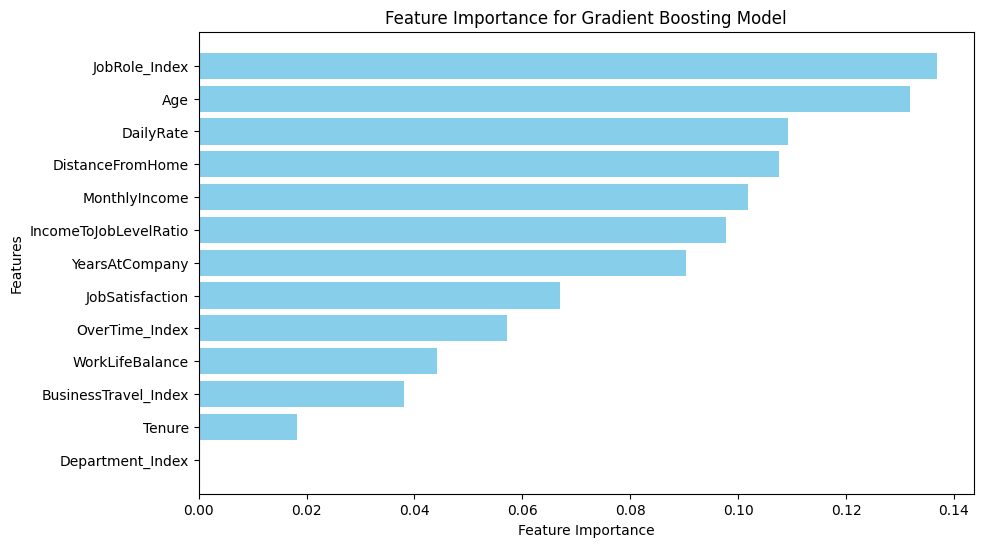

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the GBT model already trained: gbt_model
# Extract the feature importance values from the GBT model
feature_importances = gbt_model.featureImportances

# Create a DataFrame of feature names and their importance values
feature_names = feature_columns  # list of features used for training
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances.toArray()
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for Gradient Boosting Model')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


**Feature Importance for Logistic Regression (LR):**

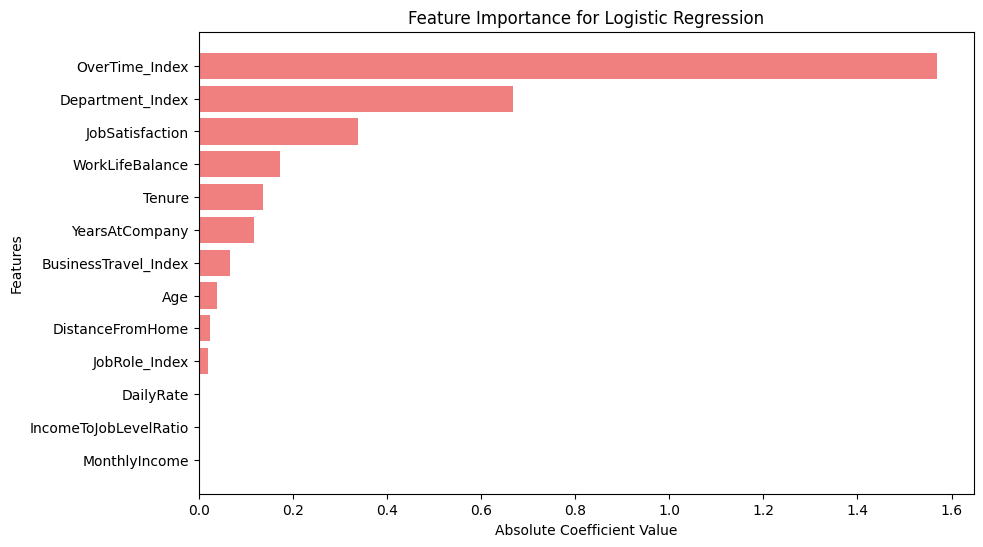

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already trained the Logistic Regression model: lr_model

# Get the coefficients of the model
coefficients = np.array(lr_model.coefficients)

# Create a DataFrame of features and their coefficients (importance)
feature_importance_lr = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': coefficients
})

# Sort features based on the absolute value of the coefficient (magnitude)
feature_importance_lr['Importance'] = feature_importance_lr['Coefficient'].apply(np.abs)
feature_importance_lr = feature_importance_lr.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_lr['Feature'], feature_importance_lr['Importance'], color='lightcoral')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance for Logistic Regression')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()


** Feature Importance for K-Nearest Neighbors (KNN):**

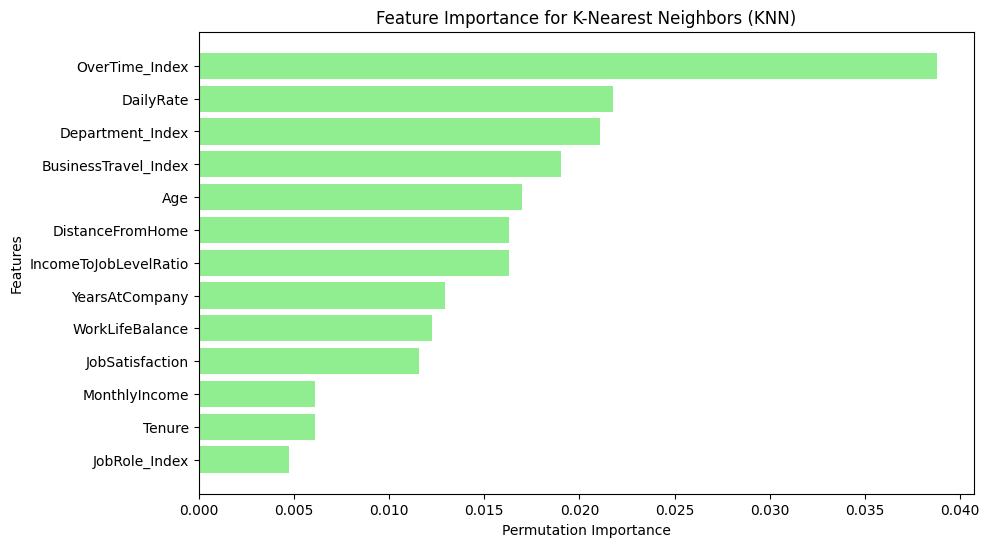

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Assuming you have already trained the KNN model: knn_model

# Calculate permutation feature importance
results = permutation_importance(knn_model, X_test, y_test, scoring='accuracy')

# Extract importance values and corresponding feature names
importance_values = results.importances_mean
feature_importance_knn = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importance_values
})

# Sort features by importance
feature_importance_knn = feature_importance_knn.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_knn['Feature'], feature_importance_knn['Importance'], color='lightgreen')
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Feature Importance for K-Nearest Neighbors (KNN)')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()
